아래의 CLASSES의 이름은 다운 받은 폴더의 이름이 일치해야 합니다. ex) data/train

In [1]:
# 우리가 분류할 4개의 클래스
#CLASSES = [ 'MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented' ]
classes = []

학습에 필요한 상수 정의

In [3]:
from pathlib import Path

# 학습에 필요한 상수들을 정의 합니다.
IMG_SHAPE = (224, 224, 3)
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
EPOCHS = 10

# 각 이미지의 기본 주소
BASE_PATH = './drive/MyDrive/Colab Notebooks/data/'
images_dir = Path(BASE_PATH).expanduser()
print(images_dir)

drive/MyDrive/Colab Notebooks/data


내 드라이브 파일 마운트하고, 폴더 정보 읽어오기

In [6]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# 모델 학습에 사용할 데이터 정보를 설정합니다.
class_list = []
num_list = []

# IMAGE_BASE_PATH = './data/'
train_path = BASE_PATH + 'train/'
for folder in os.listdir(train_path):
    classes.append(folder)
    folder_size = len(os.listdir(train_path+folder))
    class_list.append(folder)
    num_list.append(folder_size)

voc_s = pd.Series(num_list,index=class_list)
voc_s.sort_values().plot(kind='bar')
plt.show()

print(voc_s.sort_values())

NameError: name 'classes' is not defined

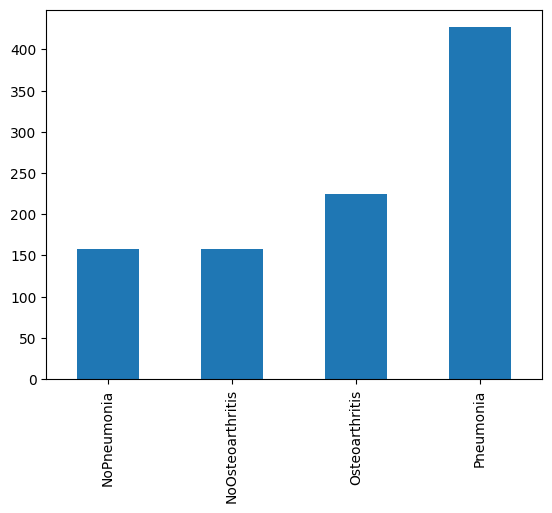

NoPneumonia         158
NoOsteoarthritis    158
Osteoarthritis      224
Pneumonia           427
dtype: int64


In [4]:
# 모델 학습 검증에 사용할 데이터 내용 입니다.

class_list = []
num_list = []

#IMAGE_BASE_PATH = './data/'
valid_path = BASE_PATH + 'test/'
for folder in os.listdir(valid_path):
    folder_size = len(os.listdir(valid_path+folder))
#     print('{:<15} : {}'.format(folder,folder_size))
    class_list.append(folder)
    num_list.append(folder_size)

voc_s = pd.Series(num_list,index=class_list)
voc_s.sort_values().plot(kind='bar')
plt.show()

print(voc_s.sort_values())

**Transfer Learning 을 통해 적은 데이터를 가지고 빠르게 학습시키기**

여기서는 기존 weight(가중치) 값을 이용하여 알츠하이머 데이터를 학습시킵니다.

In [5]:
import keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNet, MobileNetV2

# base model 의 input shape, 그리고  trainable 을 false 로 합니다.

base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

img_size = (224, 224)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet',input_shape = img_shape, pooling= 'max')

Transfer Learning 에서 정확성을 높이기 위해 마지막 3개 block 에서 모델 트레이닝합니다.

In [6]:
from tqdm import tqdm
# tqdm: progress bar를 표시해주는 패키지

# transfer learning에서 마지막 3개 block 을 사용하여 모델을 트레이닝 합니다.
set_trainable = False
for layer in tqdm(base_model.layers):
    if layer.name in ['block_14_expand','block_15_expand', 'block_16_expand']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

100%|██████████| 154/154 [00:00<00:00, 13685.68it/s]


In [7]:
# 레이어 구성을 살펴 봅니다.

layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]

pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.src.engine.input_layer.InputLayer objec...,input_1,False
1,<keras.src.layers.convolutional.conv2d.Conv2D ...,Conv1,False
2,<keras.src.layers.normalization.batch_normaliz...,bn_Conv1,False
3,<keras.src.layers.activation.relu.ReLU object ...,Conv1_relu,False
4,<keras.src.layers.convolutional.depthwise_conv...,expanded_conv_depthwise,False
...,...,...,...
149,<keras.src.layers.convolutional.conv2d.Conv2D ...,block_16_project,True
150,<keras.src.layers.normalization.batch_normaliz...,block_16_project_BN,True
151,<keras.src.layers.convolutional.conv2d.Conv2D ...,Conv_1,True
152,<keras.src.layers.normalization.batch_normaliz...,Conv_1_bn,True


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 2946948 (11.24 MB)
Trainable params: 68896

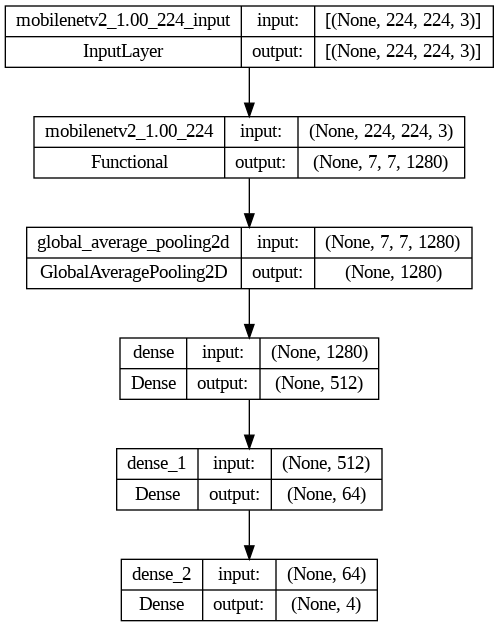

In [8]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D,GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

# 모델 만들기, 기존 모델의 weight 값을 사용하고 pooling 과 activation 함수를 추가 합니다.

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512,activation='relu'),
    Dense(64,activation='relu'),
    Dense(len(classes), activation='softmax')
])
model.summary()

png_file = BASE_PATH+'mobilenet_model.png'
plot_model(model,to_file=png_file,show_shapes=True)

모델 컴파일

In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])
model.compile(Adamax(learning_rate = 0.0001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.0001), # transfer learning 여기서 학습률을 더 작게
              metrics=['acc'])

학습 모델 정보 설정하기

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 트레인 데이터 augmentation 의로 데이터를 증가 시킴니다.

train_datagen = ImageDataGenerator(rotation_range=30,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )

train_set = train_datagen.flow_from_directory(BASE_PATH + 'train/',
                                              target_size=(224, 224),
                                              batch_size=16,
                                              shuffle=True,
                                              class_mode='categorical')

Found 7758 images belonging to 4 classes.


In [11]:
# 학습중에 validation에 사용할 데이터셋 입니다.

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_set = valid_datagen.flow_from_directory(BASE_PATH + 'test/',
                                            target_size=(224, 224),
                                            batch_size=16,
                                            shuffle=True,
                                            class_mode='categorical')

Found 967 images belonging to 4 classes.


In [12]:
# 학습을 완료후에 모델 성능 테스트에 사용할 데이터셋 입니다.

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(BASE_PATH + 'test/',
                                            target_size=(224, 224),
                                            batch_size=16,
                                            shuffle=True,
                                            class_mode='categorical')

Found 967 images belonging to 4 classes.


In [13]:
# 모델 트레이닝 입니다.

history = model.fit_generator(train_set,
                              steps_per_epoch=train_set.n // train_set.batch_size,
                              epochs=20,
                              validation_data=valid_set,
                              validation_steps=valid_set.n // valid_set.batch_size,
#                               use_multiprocessing=True,
                              )

<ipython-input-13-199a79ffbc6f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_set,


Epoch 1/20
484/484 [==============================] - 2801s 6s/step - loss: 0.4831 - acc: 0.7802 - val_loss: 0.3830 - val_acc: 0.8198
Epoch 2/20
484/484 [==============================] - 465s 960ms/step - loss: 0.3699 - acc: 0.8270 - val_loss: 0.3207 - val_acc: 0.8656
Epoch 3/20
484/484 [==============================] - 467s 964ms/step - loss: 0.3561 - acc: 0.8348 - val_loss: 0.3645 - val_acc: 0.8385
Epoch 4/20
484/484 [==============================] - 474s 980ms/step - loss: 0.3283 - acc: 0.8511 - val_loss: 0.3490 - val_acc: 0.8385
Epoch 5/20
484/484 [==============================] - 489s 1s/step - loss: 0.3341 - acc: 0.8491 - val_loss: 0.3507 - val_acc: 0.8333
Epoch 6/20
484/484 [==============================] - 453s 935ms/step - loss: 0.3260 - acc: 0.8503 - val_loss: 0.3456 - val_acc: 0.8417
Epoch 7/20
484/484 [==============================] - 468s 967ms/step - loss: 0.3204 - acc: 0.8556 - val_loss: 0.3619 - val_acc: 0.8292
Epoch 8/20
484/484 [==============================] -

학습된 모델을 저장

In [18]:
#model.save(BASE_PATH+'bin/mobilenetv2_class4.h5')
model.save(BASE_PATH+'bin/mobilenetv2_class4.tf')

test_set.class_indices.items()

In [8]:
import pickle

# key 와 value 값을 바꾸어 줍니다.
class4 = dict()
for key,value in test_set.class_indices.items():
    class4[value] = key

with open(BASE_PATH+'bin/class4.pickle', 'wb') as f:
    pickle.dump(class4, f)

NameError: name 'test_set' is not defined

In [17]:
class4

{0: 'NoOsteoarthritis', 1: 'NoPneumonia', 2: 'Osteoarthritis', 3: 'Pneumonia'}

모델 평가하기

In [19]:
# 트레인 데이터와 테스트 데이터 셋으로 loss 와 accuracy 측정합니다.

train_loss, train_acc = model.evaluate_generator(train_set)
print('Train Loss : {}'.format(train_loss))
print('Train Accuracy : {}'.format(train_acc))

test_loss, test_acc = model.evaluate_generator(test_set)
print('Test Loss : {}'.format(test_loss))
print('Test Accuracy : {}'.format(test_acc))

<ipython-input-19-d90b856d67ed>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_acc = model.evaluate_generator(train_set)


Train Loss : 0.25368762016296387
Train Accuracy : 0.8852797150611877


<ipython-input-19-d90b856d67ed>:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_set)


Test Loss : 0.33919334411621094
Test Accuracy : 0.8583247065544128


In [ ]:
# loss 측정값의 시각화 입니다.

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# accuracy 측정값의 시각화 입니다.

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1,len(loss)+1)
plt.plot(epochs,acc,label='Training Accuarcy')
plt.plot(epochs,val_acc,label='Validation Accuarcy')
plt.title('Training and Validation Accuarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuarcy')
plt.legend()

plt.show()

모델 테스트해보기

In [1]:
import cv2
from tensorflow.keras.models import load_model
import numpy as np

# 추론하기 위한 작업입니다. 모델 설정, 입력 데이터 전처리.
def predict_test_img(path):
    img = cv2.imread(path)

    #model = load_model(BASE_PATH+'bin/mobilenetv2_class4.h5')
    model = load_model(BASE_PATH+'bin/mobilenetv2_class4.tf')

    print('Original Shape : ',img.shape)

    img = cv2.resize(img, (224,224), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    print('Resized Shape : ',img.shape)
    plt.imshow(img)
    plt.show()

    #ans = model.predict_classes(np.expand_dims(img,axis=0))

    predicted_result = model.predict(np.expand_dims(img,axis=0))
    ans = np.round(predicted_result).astype(int)
    with open(BASE_PATH+'bin/class4.pickle','rb') as f:
        class4 = pickle.load(f)
    res = -1
    for x in range(4):
      if ans[0][x] == 1: res = x
    print('Predict : {}'.format(class4[res]))

    #predicted_result = model.predict(np.expand_dims(img,axis=0))
    pd.DataFrame(predicted_result,columns=class4.values()).iloc[0].plot(kind='bar')
    plt.show()

Original Shape :  (224, 224, 3)
Resized Shape :  (224, 224, 3)


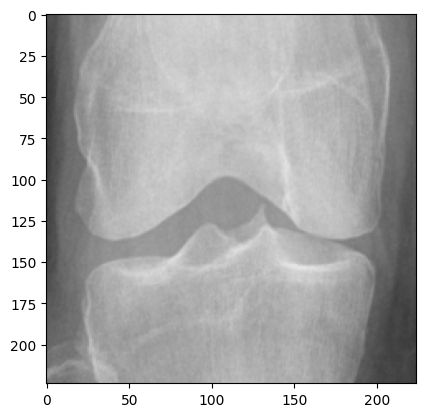

1/1 [==============================] - 1s 1s/step
Predict : NoOsteoarthritis


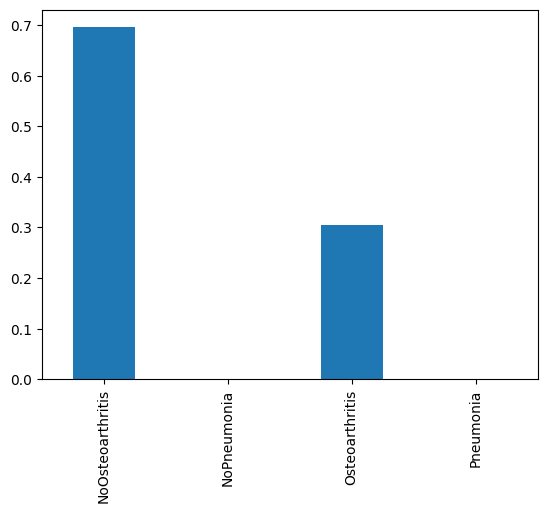

In [9]:
# 기존에 사용되지 않았던 임의 데이터를 추론 하기
predict_test_img(BASE_PATH+'test/NoOsteoarthritis/_IQk_5.jpg')

Original Shape :  (224, 224, 3)
Resized Shape :  (224, 224, 3)


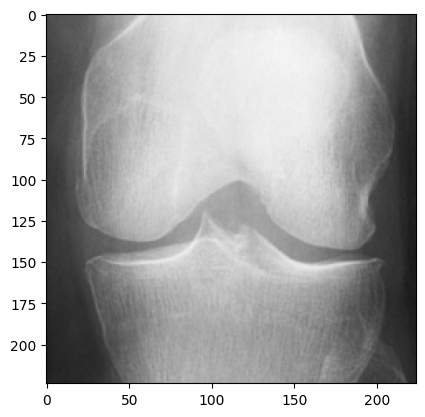

1/1 [==============================] - 1s 967ms/step
Predict : NoOsteoarthritis


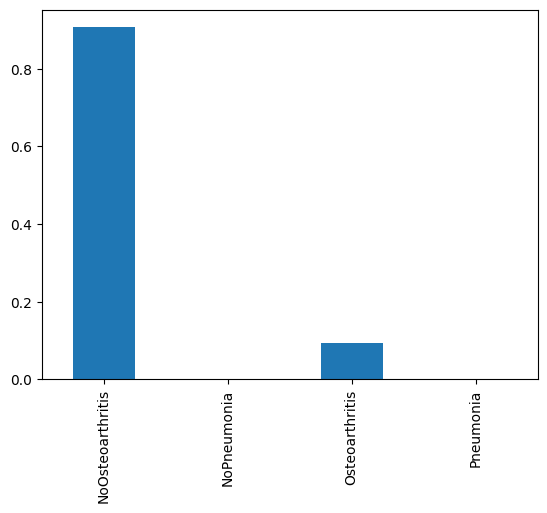

In [10]:
predict_test_img(BASE_PATH+'test/Osteoarthritis/0Ja5f6.jpg')

Original Shape :  (504, 840, 3)
Resized Shape :  (224, 224, 3)


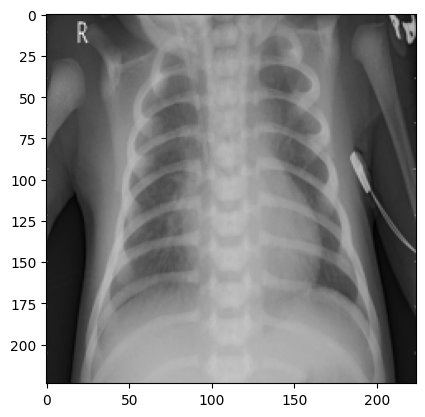

1/1 [==============================] - 1s 1s/step
Predict : Pneumonia


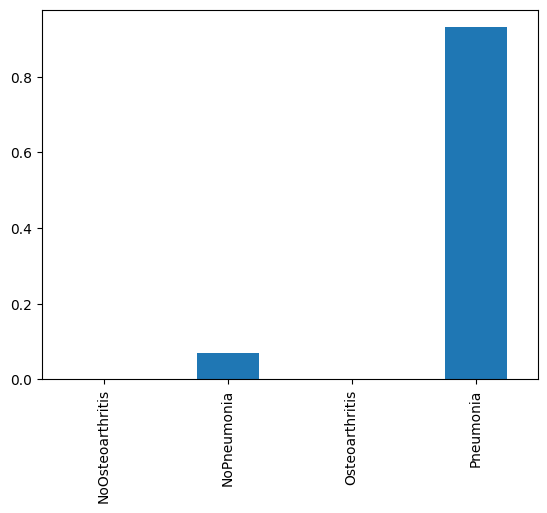

In [11]:
predict_test_img(BASE_PATH+'test/Pneumonia/G6YR7a.jpg')

Original Shape :  (813, 1256, 3)
Resized Shape :  (224, 224, 3)


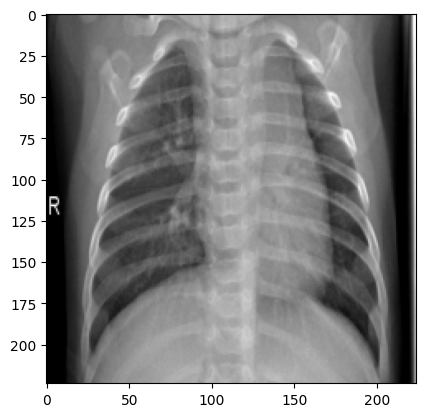

1/1 [==============================] - 1s 992ms/step
Predict : NoPneumonia


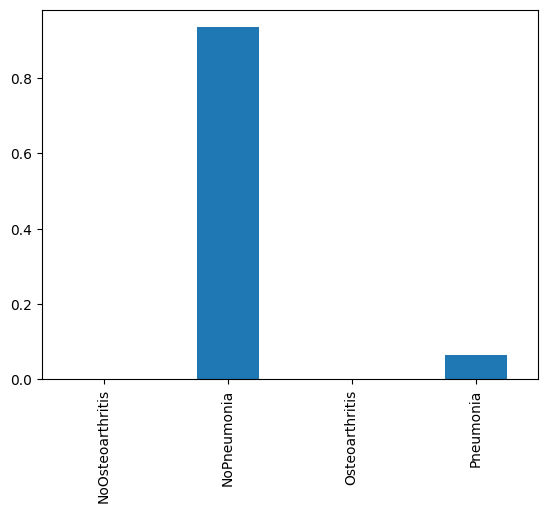

In [12]:
predict_test_img(BASE_PATH+'test/NoPneumonia/K__jw0.jpg')